## H&M Personalized Fashion Recommendation Systems

Github link - https://github.com/sam00345/H-M-Fashion-Recommendation-Systems

### Problem Statement

H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores with their online store has an extensive selection of products to browse through. But with too many choices, customers might not quickly find what interests them or what they are looking for, and ultimately, they might not make a purchase. To enhance the shopping experience, product recommendations are key. More importantly, helping customers make the right choices also has a positive implications for sustainability, as it reduces returns, and thereby minimizes emissions from transportation.

The goal is to develop product recommendations based on data from previous transactions, as well as from customer and product meta data. The available meta data spans from simple data, such as garment type and customer age, to text data from product descriptions, to image data from garment images.

### Project Goals

* The primary goal of this project is to use Unsupervised Machine Learning techniques such as similarity metrics and build recommendation systems to predict the items which the customer would purchase 

* The Machine learning models will be trained on H&M's item and transaction data using which the model learns from the data, and creates its own algorithm to make predictions for each customer in the test dataset.

* Predictions will be made by the models which will be compared with actual data to evaluate the performance and reliability of the model.

* Validation and Evaluation of the models will be done using standard scoring metrics designed for Recommender System (Recall@K) based on the results of the predictions. 

* The recommender systems we will build will include Baseline, Content Based, Collaborative Filtering and Hybrid Recommender Systems

### Data Description

The data used in this project is from a Kaggle competition cited below:

Carlos García Ling. (2022). H&M Personalized Fashion Recommendations. Kaggle. https://kaggle.com/competitions/h-and-m-personalized-fashion-recommendations

The dataset contains the following files:
* articles.csv - detailed metadata for each article_id available for purchase. Contains 105,542 rows/articles
* customers.csv - metadata for each customer_id in dataset. Contains 1,371,980 rows/customers
* transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Contains 31,788,324 rows/transactions
* sales.parquet - paruqet format of the transactions_train.csv data containing additional info such as the day/week of purchase
* images/ - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

The task in the competition is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period. However, given the huge amount of data to process, we will only try to predict the purchases in the 1-day period following training data to keep the compute time manageable on a laptop. 

Also, since the provided dataset does not contain a test set/validation set, we will split the transactions_train.csv into training and test set, so that the predictions can be evaluated on the test set. 


### Library import and Data Loading
* Let us start by importing the necessary libraries and loading the dataset using Pandas. 

* We will not load or use the customers.csv as most of the data in it is not useful for our purpose. Age and postal_code is the only relavent columns within it for our prediction purpose, but we will instead rely on the transactions_train data for the model to build understanding of customers based on their past purchases.

* We will also use the images data to visualize the recommendations of different models along with the customer purchase history

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from wordcloud import WordCloud
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import zipfile
import os
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load datasets
articles = pd.read_csv('articles.csv')
all_transactions = pd.read_csv('transactions_train.csv')
sales = pd.read_parquet('sales.parquet')

# Convert date to datetime
all_transactions['t_dat'] = pd.to_datetime(all_transactions['t_dat'])


Now we will split the transactions data into training and test sets. As noted earlier, the test data will be the last 1 day of the transaction data.

In [2]:
# Get the max date in the dataset
max_date = all_transactions['t_dat'].max()

# Define the test period: the last 1 day of the dataset
test_start_date = max_date - pd.Timedelta(days=1)

# Split data
train_data = all_transactions[all_transactions['t_dat'] <= test_start_date]
test_data = all_transactions[all_transactions['t_dat'] > test_start_date]

### Data Inspection

* Let us inspect the data by checking the train and test data size and also printing the first 5 rows of the train data containing transactions

In [3]:
print("Size of Training data - ",train_data.shape)
print("Size of Test data - ",test_data.shape)
train_data.head()

Size of Training data -  (31755458, 5)
Size of Test data -  (32866, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


* We can see that each row corresponds to a transaction involving a `customer_id` and `article_id` along with the price and time

We will now try to see the number of unique values in each of these columns, and also check for missing values in any of the columns in the train data

In [4]:
print('Number of Unique values \n', train_data.nunique())

print('\n Number of missing values \n', train_data.isnull().sum())

Number of Unique values 
 t_dat                   733
customer_id         1361383
article_id           104445
price                  9857
sales_channel_id          2
dtype: int64

 Number of missing values 
 t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


* We see that the number of unique `article_id` are 104,445 which is close to the 105,542 articles we have in the articles.csv
* The number of unique customers who made a purchase during this time frame are 1,361,383
* We can also see that there are no missing values in any of the columns which is good

Now we will inspect the articles data by checking the data size and also printing the first 5 rows of the articles dataframe

In [5]:
print("Size of Articles data - ",articles.shape)
articles.head()

Size of Articles data -  (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


* We can confirm the number of rows in the articles dataframe as 105,542 with 25 columns
* The columns include various information about each article such as the type, color, description, etc

We will now check for missing values in any of the columns in the articles data

In [6]:
print('\n Number of missing values \n', articles.isnull().sum())


 Number of missing values 
 article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64


* We see that only a small number of 416 articles are missing a description out of the 105,542 articles. All other columns don't have any missing values

### Data wrangling and cleaning

We will now clean up the `detail_desc` by lowercasing all words, removing puntuation and stopwords. We will also replace the missing values found earlier with empty string

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Lowercasing the data
    text = text.lower()
    # Removing punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Removing stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

articles['cleaned_detail_desc'] = articles['detail_desc'].fillna('').apply(preprocess_text)

articles[['cleaned_detail_desc','detail_desc']].sample(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sameer.chowdary.gaddam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cleaned_detail_desc,detail_desc
26490,long sleeveless dress airy chiffon pleats top ...,"Long, sleeveless dress in airy chiffon with pl..."
56163,baby exclusive dress soft doubleweave organic ...,"Baby Exclusive. Dress in soft, double-weave or..."
95166,fitted cropped sleeveless top rib knit wide fl...,"Fitted, cropped, sleeveless top in a rib knit ..."
52747,sports bra fastdrying functional fabric jacqua...,Sports bra in fast-drying functional fabric wi...
24592,checked twill jacket notch lapels buttons fron...,"Checked twill jacket with notch lapels, button..."


We can see how the stopwords/common words have been removed along with the other pre-processing. The rest of the data data is clean and does not require any further cleanup. We can proceed to visualizing the data!

### Exploratory Data Analysis

Let us start by visualizing the 20 most common words found in the descriptions of each article

Text(0.5, 1.0, 'Top 20 Words in the Article description')

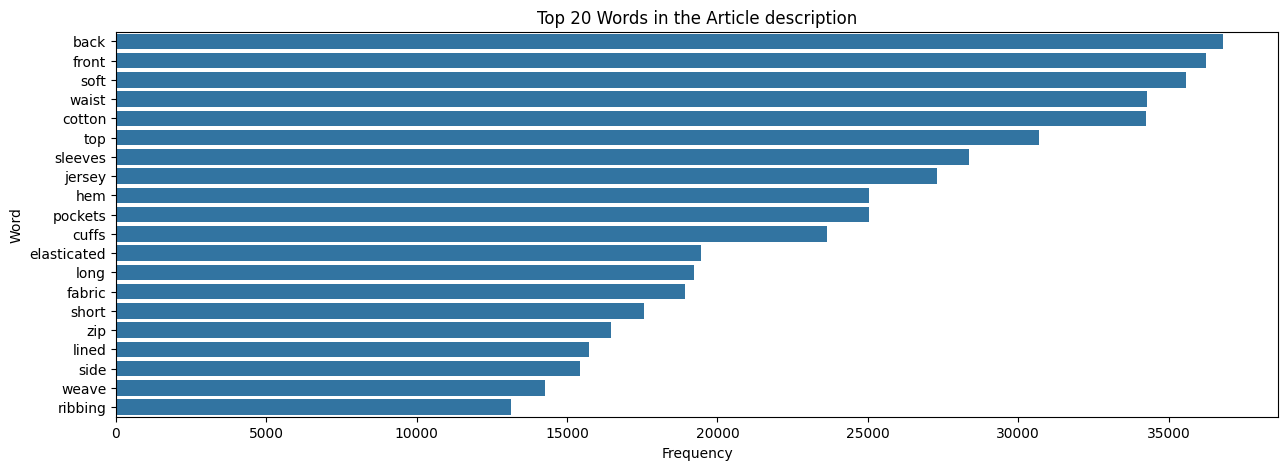

In [8]:
plt.figure(figsize=(15,5))
words = ' '.join([str(text) for text in articles['cleaned_detail_desc']])
words_freq = Counter(words.split()).most_common(20)
words_df = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])    
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Top 20 Words in the Article description')

The most common words mostly seem to be clothing related which is expected. They also indicate some information about the article which is good for our model building

Now let us visualize the `garment_group_name` and `index_group_name` in the article data

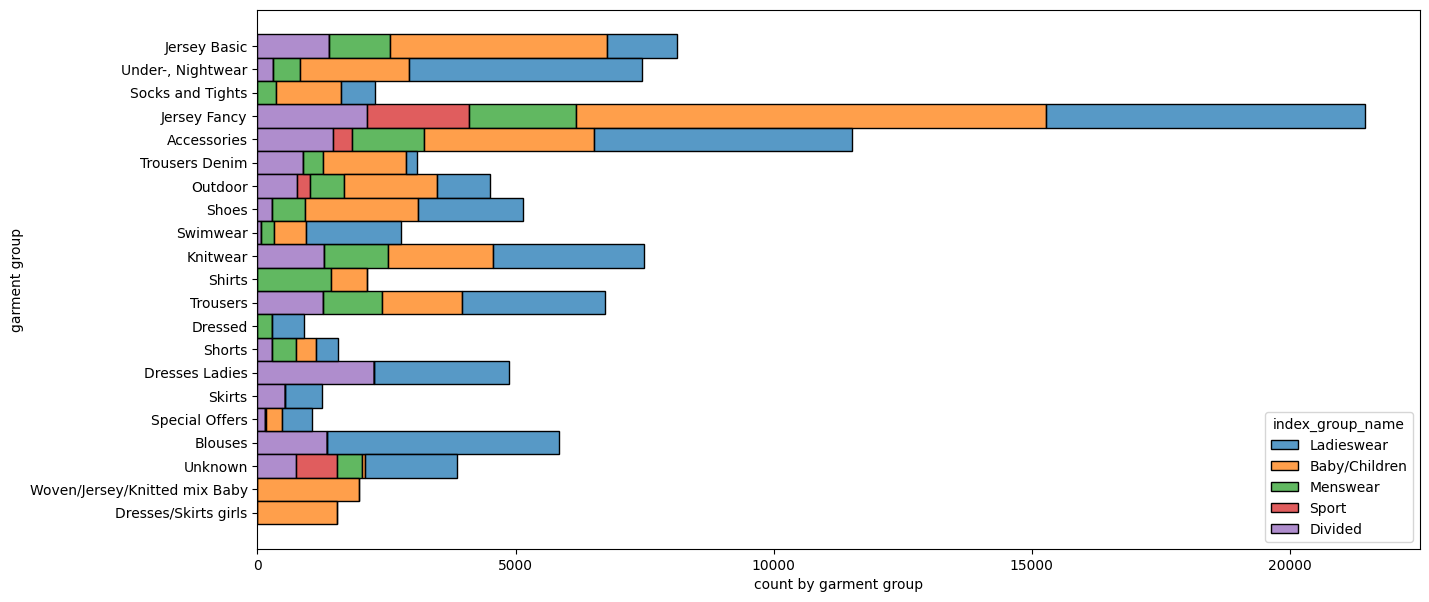

In [9]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

* 'Jersey Fancy' garment group has the highest number of articles followed by 'Accessories' and other garment groups. 
* We also notice that 'Ladieswear' index group name has the highest number of articles among the other index group names

Now let us visualize the transactions data starting with the price of each transaction based on the article product type

Text(0.5, 1.0, 'Distribution of Prices for Product Groups')

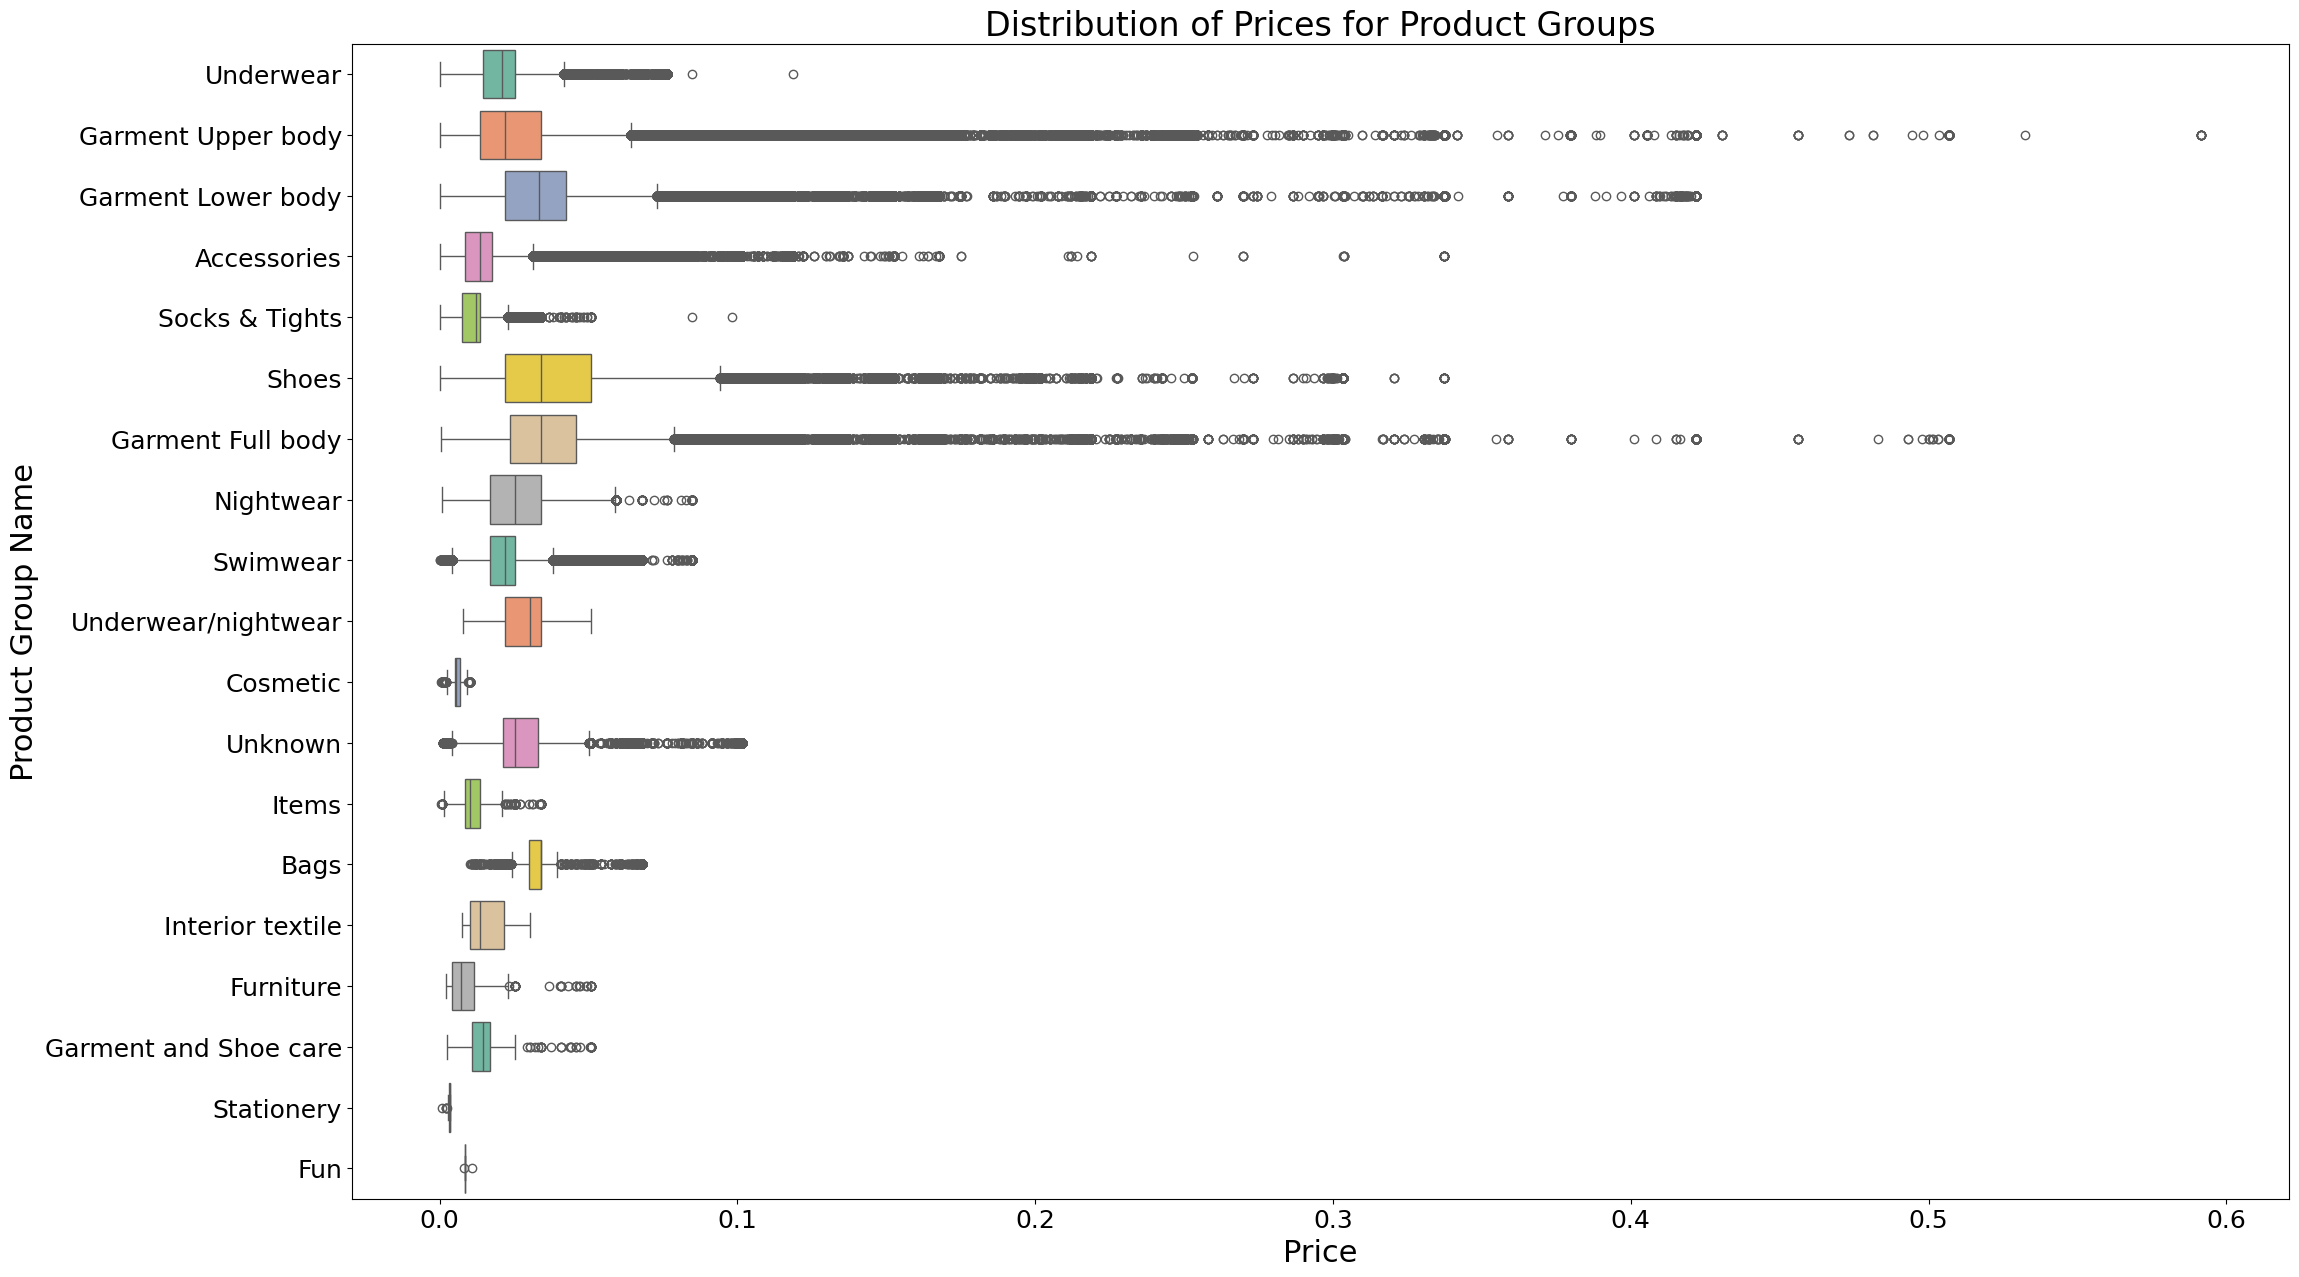

In [10]:
articles_merge = articles[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]
articles_merge = train_data[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_merge, on='article_id', how='left')

plt.figure(figsize=(25, 15))
ax = sns.boxplot(data=articles_merge, x='price', y='product_group_name', hue='product_group_name',palette='Set2')

ax.set_xlabel('Price', fontsize=22)
ax.set_ylabel('Product Group Name', fontsize=22)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title('Distribution of Prices for Product Groups', fontsize=24)


We see that the variance is highest for shoes, and upper/lower/full garments. There are also quite a few outliers for garments potentially due to high-end products in this group

The training data consists of 2 years of data which is huge. The goal is to only predict the purchases at the end of this 2 year period. We will visualize the sales of articles in a given week grouped by the last purchased week. This is to check if any items which were last purchased much earlier get purchased even after a long duration

In [11]:
sales_per_week = sales.groupby(['article_id', 'week'], as_index=False).agg(unit_sales=('price', 'size')).sort_values('week')
sales_per_week['last_purchase_week'] = sales_per_week.groupby('article_id').week.diff()
sales_per_week.loc[sales_per_week.last_purchase_week.isna(), 'last_purchase_week'] = 0
sales_per_week['last_purchase_week_bin'] = pd.cut(sales_per_week.last_purchase_week, bins=[0, 1, 2, 3, 4, 5, 105], labels=['new', '1 week before', '2 weeks before', '3 weeks before', '4 weeks before', '>=5 weeks before'], right=False)
sales_per_week = sales_per_week.groupby(['week', 'last_purchase_week_bin'], observed=False).agg(unit_sales=('unit_sales', 'sum'), article_count=('article_id', pd.Series.nunique)).reset_index()
sales_per_week['unit_sales_pct'] = sales_per_week['unit_sales']/sales_per_week.groupby('week').unit_sales.transform('sum')*100

# Plot stacked bar plot
px.bar(sales_per_week, x='week', y='article_count', color='last_purchase_week_bin', title='Number of unique articles per week')

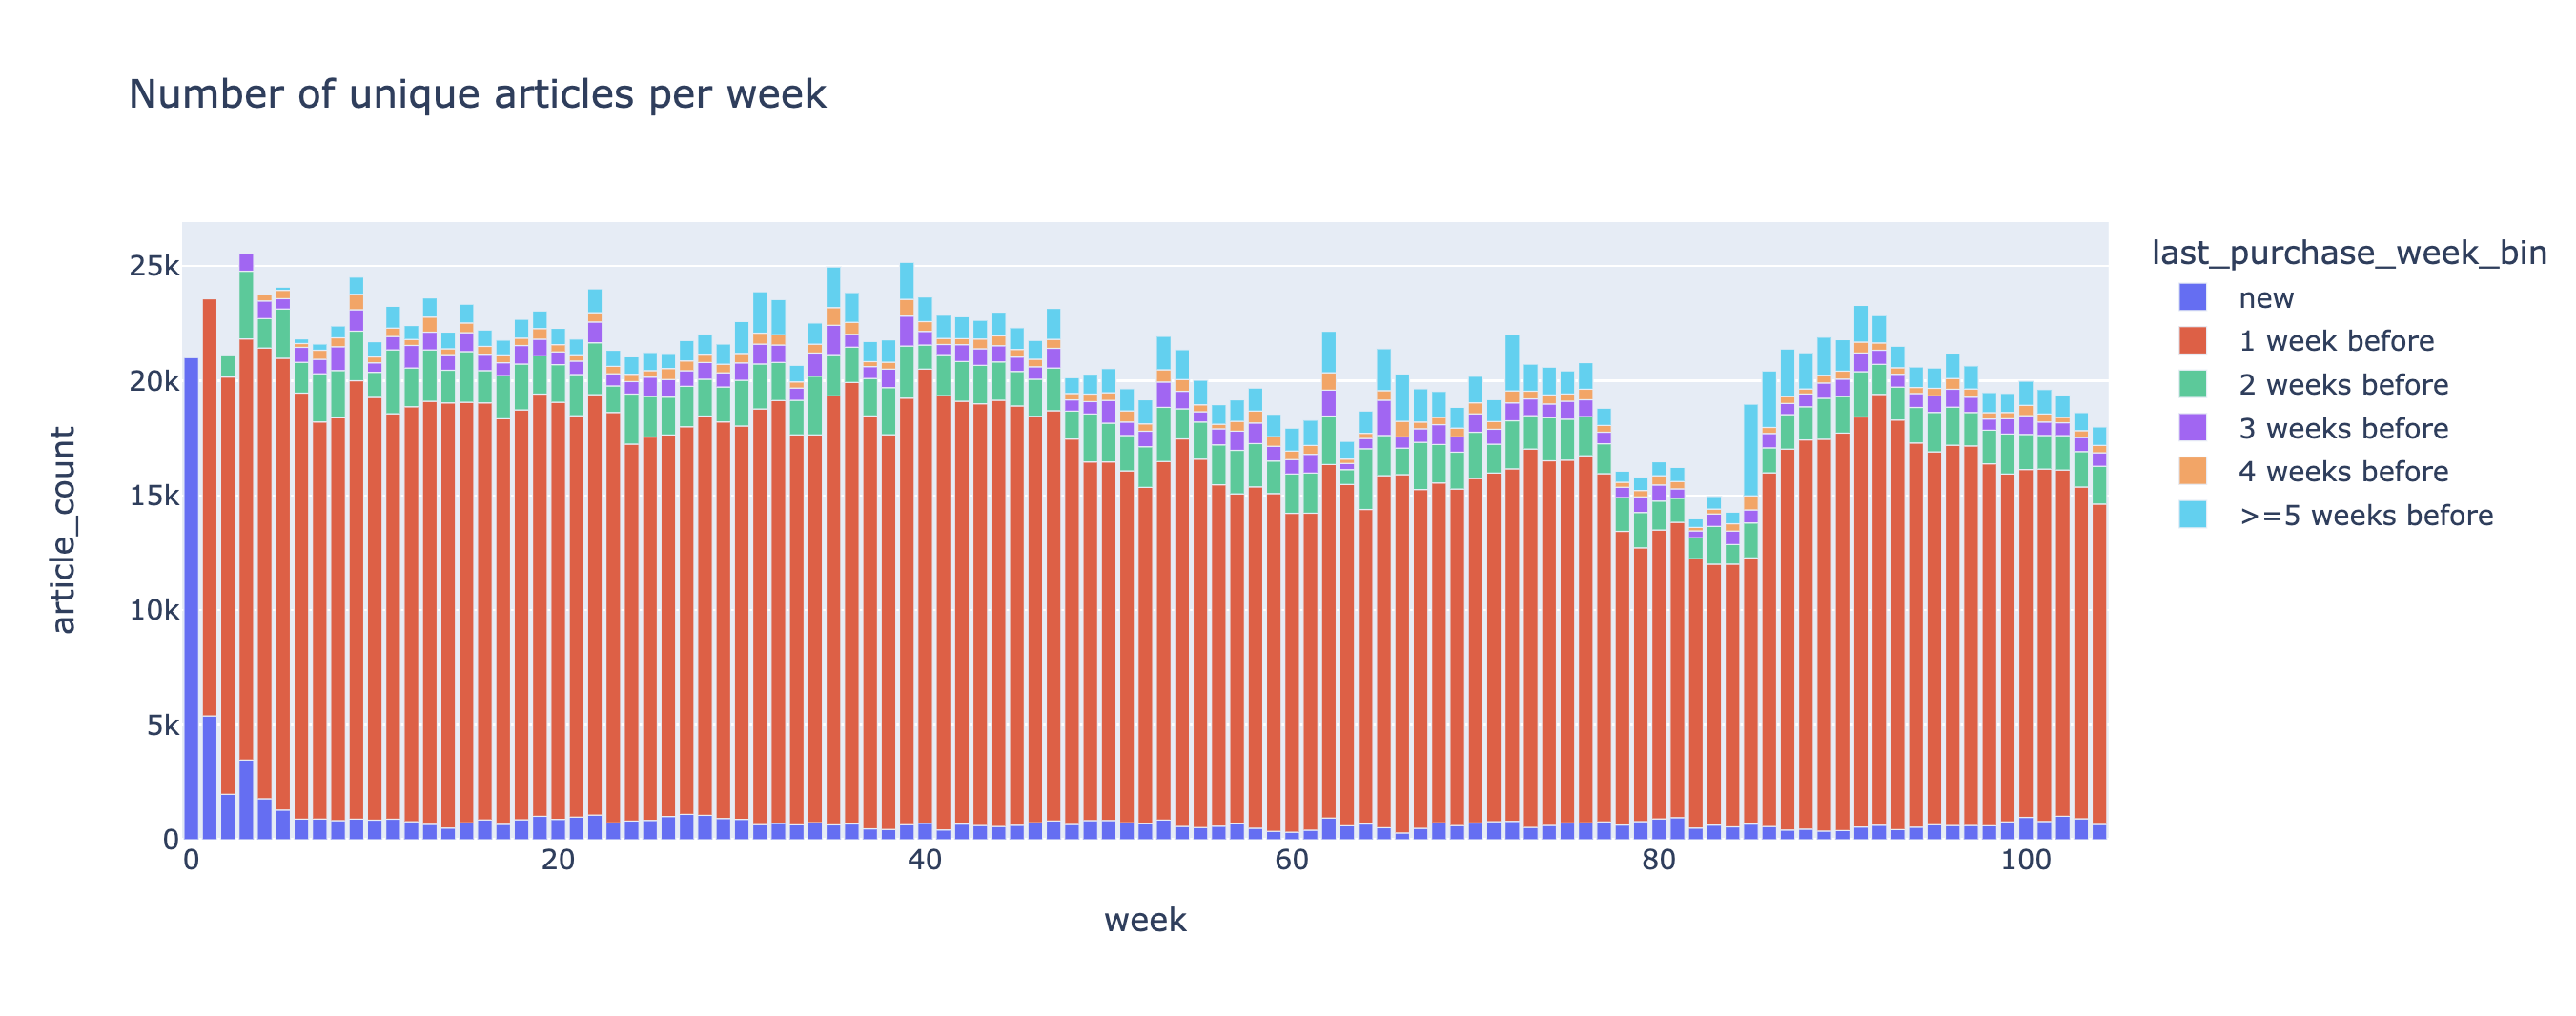

We can clearly see that majority of the articles being purchased in any given week have been purchased in the prior week. Hence, in order to predict the purchases following the training data, we would only require the last week of purchases in the training data. Also, we will only use 3 days rather than a week to keep the compute time faster for building our models

Let us filter the training data to only the last 3 days which we will use for our models. We will also filter the articles data with the articles purchased only in these 3 days

In [12]:
# Filter transactions based on the training period
train_max_date = train_data['t_dat'].max()
train_cutoff_date = max_date - pd.Timedelta(days=3)
transactions = train_data[train_data['t_dat'] > train_cutoff_date]
articles = articles.loc[articles['article_id'].isin(transactions['article_id'].unique())]
articles = articles.reset_index(drop=True)

### Baseline Model and Evaluation

We will start with a baseline model which predicts the 12 most purchased articles in the training set. 

The chosen evaluation metric will be **Recall@K** which is a popular metric for scoring recommender systems and is defined as:

$$

\text{Recall@}k = \frac{\text{Number of relevant items in top } k \text{ recommendations}}{\text{Total number of relevant items}}

$$


The k will be 12 in our case, which equals the total number of recommendations we will be making for each customer


In [13]:
# Function to calculate Recall@12
def recall_at_k(actual_purchases, predicted_articles, k=12):
    actual_set = set(actual_purchases)
    predicted_set = set(predicted_articles[:k])
    
    # Calculate recall as the fraction of relevant items found
    recall = len(actual_set & predicted_set) / len(actual_set)
    return recall

baseline_predictions = train_data['article_id'].value_counts().index[:12]

# Customers who made purchases in the test data
test_customers = test_data['customer_id'].unique()

#  Evaluate recall for all customers in the test set
total_recall = 0
count = 0

# Generate recommendations and calculate recall for each test customer
for customer_id in test_customers:
    # Get the actual articles purchased by this customer in the test set
    actual_purchases = test_data[test_data['customer_id'] == customer_id]['article_id'].values
    
    # Get predicted articles with baseline predictions
    predicted_articles = baseline_predictions
    
    if len(actual_purchases) > 0:
        # Calculate recall@12 for this customer
        recall = recall_at_k(actual_purchases, predicted_articles, k=12)
        total_recall += recall
        count += 1

# Calculate average recall@12 over all test customers
average_recall = total_recall / count if count > 0 else 0
print(f'Average Recall@12 (Baseline): {average_recall:.4f}')

Average Recall@12 (Baseline): 0.0077


The Recall@K such a recommender system based on such a huge inventory of items is expected to be low. We see that for our baseline model, it is 0.0077 which is still quite low. 

Let us view the Baseline recommended items for a random customer in the test set along with the items purchased by the same customer in train and test sets

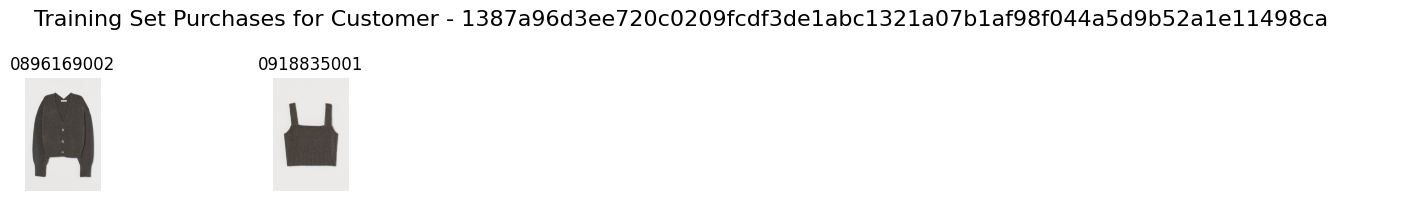

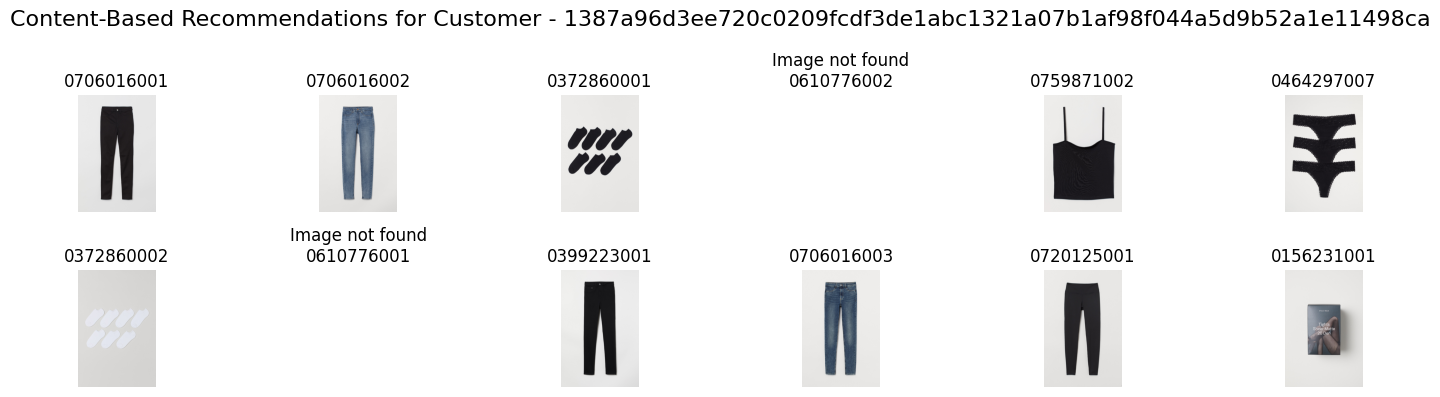

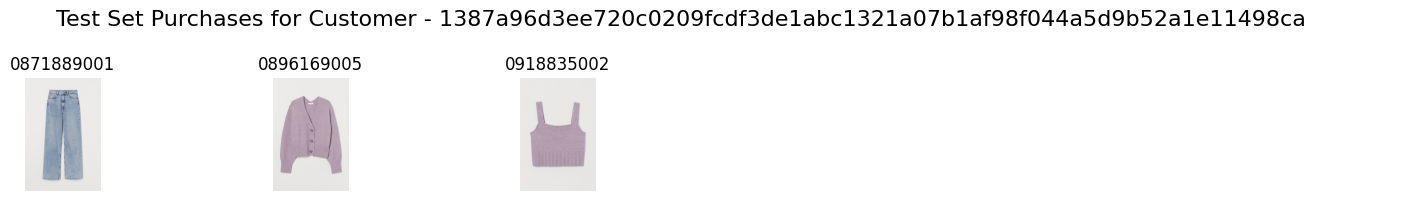

In [14]:

# Path to the images.zip file
zip_path = "images.zip"

# Function to load and display images from the zip file given article_ids
def display_images_from_zip(article_ids, title, n_cols=6):
    n_rows = (len(article_ids) + n_cols - 1) // n_cols  # Calculate number of rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_rows))
    
    # Check if axes is a 2D array or a single axis, adjust accordingly
    if n_rows == 1 and n_cols == 1:
        axes = [axes]  # Convert single axis to list for uniformity
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()  # Flatten if it's a 1D array of subplots
    else:
        axes = axes.ravel()  # Flatten if it's a 2D array of subplots

    fig.suptitle(title, fontsize=16)
    
    with zipfile.ZipFile(zip_path, 'r') as archive:
        for i, article_id in enumerate(article_ids):
            # Ensure article_id is a string
            article_id_str = '0' + str(article_id)
            
            # Extract the first two characters and prepend a '0' to create the folder name
            folder_name = article_id_str[:3]
            
            # Locate the image path in the zip (folder is the first 2 characters of article_id with '0' prepended)
            image_file = f"{folder_name}/{article_id_str}.jpg"
            
            try:
                # Extract the image from the zip file and open it using PIL
                with archive.open(image_file) as image_data:
                    img = Image.open(BytesIO(image_data.read()))
                    axes[i].imshow(img)  # Plot the image on the appropriate subplot
                    axes[i].set_title(article_id_str)
                    axes[i].axis("off")
            except KeyError:
                # Handle missing images
                axes[i].set_title(f"Image not found\n{article_id_str}")
                axes[i].axis("off")

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

# Try it on a customer in the test set
trial_customer_id = '1387a96d3ee720c0209fcdf3de1abc1321a07b1af98f044a5d9b52a1e11498ca'

# Get the articles the customer purchased in the training set
customer_train_purchases = transactions[transactions['customer_id'] == trial_customer_id]['article_id'].unique()

# Get the articles the customer purchased in the test set
customer_test_purchases = test_data[test_data['customer_id'] == trial_customer_id]['article_id'].unique()

# Display images of articles purchased in the training set
display_images_from_zip(customer_train_purchases, title=f"Training Set Purchases for Customer - {trial_customer_id}")

# Display images of Baseline recommendations
display_images_from_zip(baseline_predictions, title=f"Content-Based Recommendations for Customer - {trial_customer_id}")

# Display images of articles purchased in the test set
display_images_from_zip(customer_test_purchases, title=f"Test Set Purchases for Customer - {trial_customer_id}")


* We see the customer purchased 2 articles in the training set. 
* The baseline recommendations do not seem to be quite related to the previously purchased articles as the baseline recommendations are based on most purchased by all customers. A couple of baseline recommendations does not have images but it does not impact the prediction or evaluation. 
* We also see the customer purchased 3 articles in the test set, which do not coincide with the baseline recommendations giving a some explanation about the poor Recall@K metric for baseline recommendations. 

Let us apply Content Based filtering to see if we can improve the predictions

### Content Based Recommender System

* In content-based filtering, we'll recommend articles based on their similarity in terms of features (descriptions) to articles a customer has purchased in the past. 
* We could use other features in the articles data such as garment group name or index group name as we visualized earlier, but the description seems to contain more detailed information on each of the articles. So we will simply use the article description to calculate the similarity matrix.
* We will implement TF-IDF Vectorization for word embedding where the weight for each word is proportional to its term frequency (TF) and inversely proportional to its document frequency (IDF)
* For each customer, we will compute the cosine similarity between the descriptions of articles they've purchased and all other articles.
* Then we will rank the articles by similarity and recommend the top 12 articles for each customer in the test set.

In [15]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(articles['cleaned_detail_desc'].fillna(''))

# Compute cosine similarity between articles
article_similarity = cosine_similarity(tfidf_matrix)

most_purchased = transactions['article_id'].value_counts().index[:12]

# Create a function to recommend based on content (similarity of descriptions)
def recommend_articles_content_based(customer_id, n_recommendations=12):
    customer_transactions = transactions[transactions['customer_id'] == customer_id]
    purchased_articles = customer_transactions['article_id'].unique()
    purchased_articles_idx = articles.loc[articles['article_id'].isin(purchased_articles)].index.tolist()
    
    # Calculate the average similarity score for all other articles
    article_scores = article_similarity[purchased_articles_idx].mean(axis=0)
    
    # Recommend top N articles
    top_indices = article_scores.argsort()[-n_recommendations:][::-1]
    recommended_articles = articles.iloc[top_indices]['article_id'].values
    
    return recommended_articles


Let us generate the predictions/recommendations for each customer present in the test set, and calculate the Recall@K metric. We will also visualize the articles recommended by content-based filtering as we did for baseline predictions

Average Recall@12 (Content Based Filtering): 0.0465


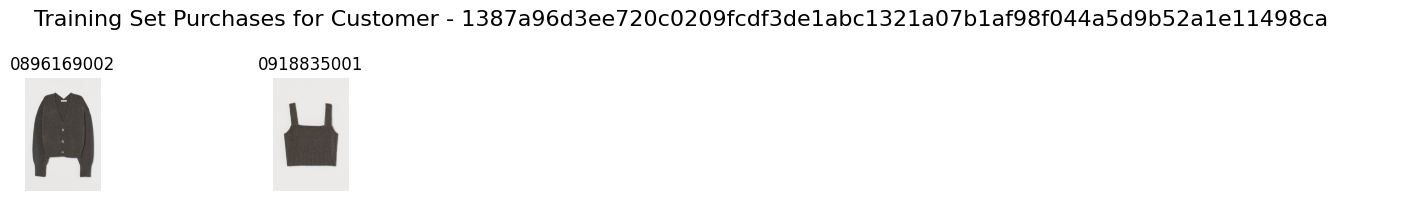

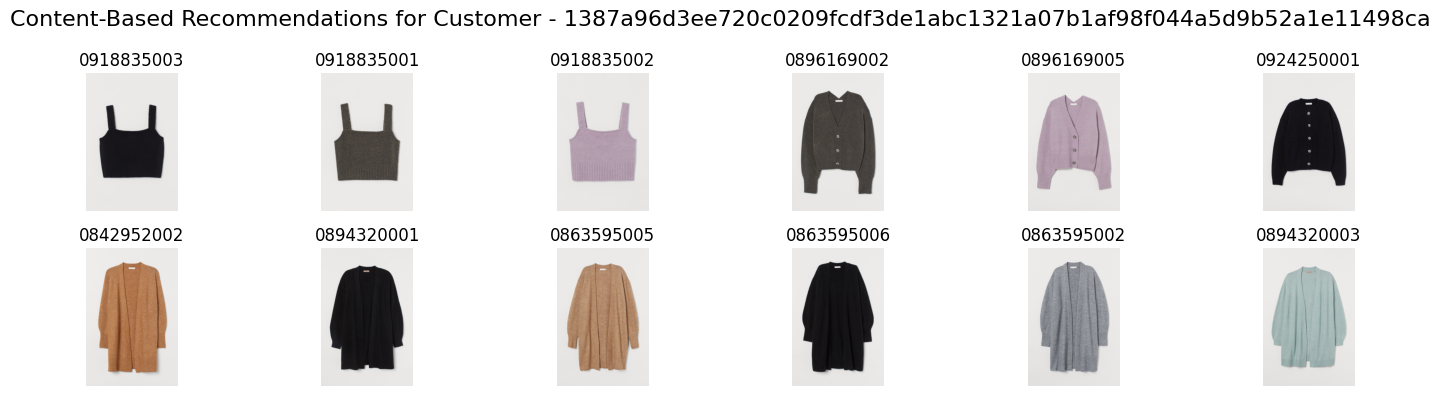

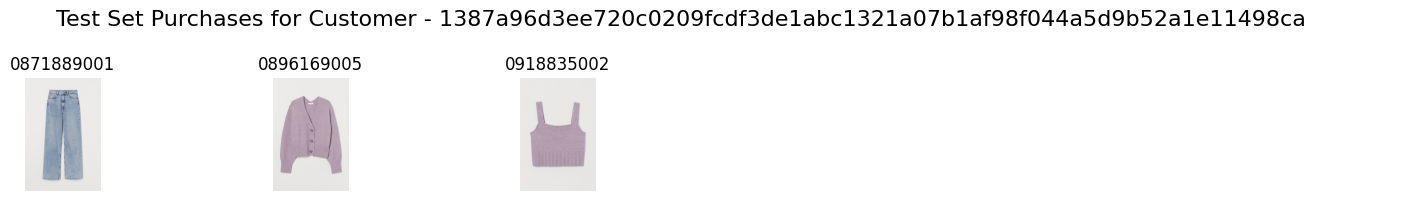

In [16]:

predictions = {}
for customer_id in test_customers:
    if customer_id in transactions['customer_id'].values:
        # Generate recommendations
        predictions[customer_id] = recommend_articles_content_based(customer_id)
    else:
        # If no purchase history, recommend the most purchased articles
        predictions[customer_id] = most_purchased


#  Evaluate recall for all customers in the test set
total_recall = 0
count = 0

for customer_id in test_customers:
    # Get the actual articles purchased by this customer in the test set
    actual_purchases = test_data[test_data['customer_id'] == customer_id]['article_id'].values
    
    # Get predicted articles for the customer
    predicted_articles = predictions.get(customer_id, [])
    
    if len(actual_purchases) > 0:
        # Calculate recall@12
        recall = recall_at_k(actual_purchases, predicted_articles, k=12)
        total_recall += recall
        count += 1

# Calculate the average recall@12
average_recall = total_recall / count
print(f'Average Recall@12 (Content Based Filtering): {average_recall:.4f}')

# Get the articles the customer purchased in the training set
customer_train_purchases = transactions[transactions['customer_id'] == trial_customer_id]['article_id'].unique()

# Get the content-based recommendations for this customer
content_based_recommendations = recommend_articles_content_based(trial_customer_id)

# Get the articles the customer purchased in the test set
customer_test_purchases = test_data[test_data['customer_id'] == trial_customer_id]['article_id'].unique()


# Display images of articles purchased in the training set
display_images_from_zip(customer_train_purchases, title=f"Training Set Purchases for Customer - {trial_customer_id}")

# Display images of content-based recommendations
display_images_from_zip(content_based_recommendations, title=f"Content-Based Recommendations for Customer - {trial_customer_id}")

# Display images of articles purchased in the test set
display_images_from_zip(customer_test_purchases, title=f"Test Set Purchases for Customer - {trial_customer_id}")

* We see the Recall@K metric has significantly improved compared to baseline model.
* We also notice that the articles recommended by Content based filtering are very physically similiar to the articles purchased by the same customer in the training set which is expected as content based is using the article description to build the similarity matrix. 
* We also see that 2 of the articles purchased by the customer are included in the recommendations giving us an idea of how content based filtering may have significantly improved the Recall@K metric

Now we will try a Collaborative filtering approach using matrix factorization

### Collaborative Filtering using Matrix Factorization (SVD)

* Collaborative filtering recommends items based on the purchases of other customers with similar purchase patterns. It uses the user-item interaction data to make predictions.
* We will create a customer-article interaction matrix from transactions data, where rows are customers and columns are articles, with entries representing the number of times a customer has purchased an article.
* Then we will use matrix factorization (SVD) to learn latent factors that capture user and item relationships.
* For each customer in the test set, we will predict the top 12 articles they are likely to buy based on the reconstructed matrix

In [17]:

#  Build the user-item interaction matrix
customer_ids = transactions['customer_id'].unique()
article_ids = articles['article_id'].unique()

# Create mappings for indices
customer_index = {customer_id: idx for idx, customer_id in enumerate(customer_ids)}
article_index = {article_id: idx for idx, article_id in enumerate(article_ids)}

# Initialize the user-item matrix
user_item_matrix = np.zeros((len(customer_ids), len(article_ids)))

# Populate the matrix with transaction data
for _, row in transactions.iterrows():
    user_idx = customer_index.get(row['customer_id'])
    article_idx = article_index.get(row['article_id'])
    if user_idx is not None and article_idx is not None:
        user_item_matrix[user_idx, article_idx] += 1  # Increment count of purchases

# Apply SVD for matrix factorization with k latent factors
k = 20 
U, sigma, Vt = svds(user_item_matrix, k=k)

# Convert sigma (which is a 1D array) to a diagonal matrix
sigma = np.diag(sigma)

# Reconstruct the user-item matrix using latent features
predicted_ratings = np.dot(np.dot(U, sigma), Vt)


In [18]:
# Define the collaborative filtering recommendation function using SVD
def recommend_articles_svd(customer_id, n_recommendations=12):
    # Get the user's index in the user-item matrix
    if customer_id not in customer_index:
        # If the customer is new, recommend the most purchased articles
        return most_purchased
    
    user_idx = customer_index[customer_id]
    
    # Get the predicted ratings for this user
    user_ratings = predicted_ratings[user_idx]
    
    # Exclude articles the user has already purchased
    purchased_articles = user_item_matrix[user_idx].nonzero()[0]
    user_ratings[purchased_articles] = -np.inf  # Exclude already purchased items
    
    # Recommend top N articles based on predicted ratings
    top_indices = user_ratings.argsort()[-n_recommendations:][::-1]
    recommended_articles = articles.iloc[top_indices]['article_id'].values
    
    return recommended_articles


Let us generate the predictions/recommendations for each customer present in the test set, calculate the Recall@K metric and visualize the recommendations

Average Recall@12 (Collaborative Filtering using SVD): 0.0305


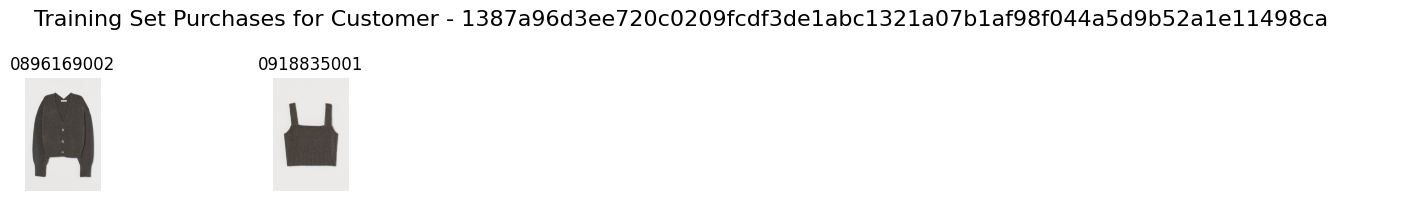

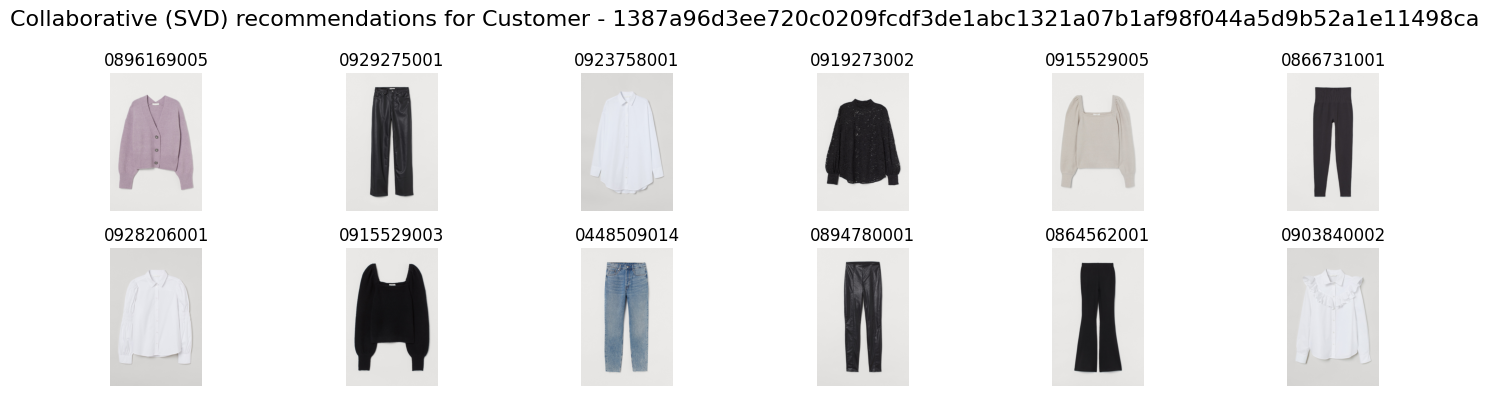

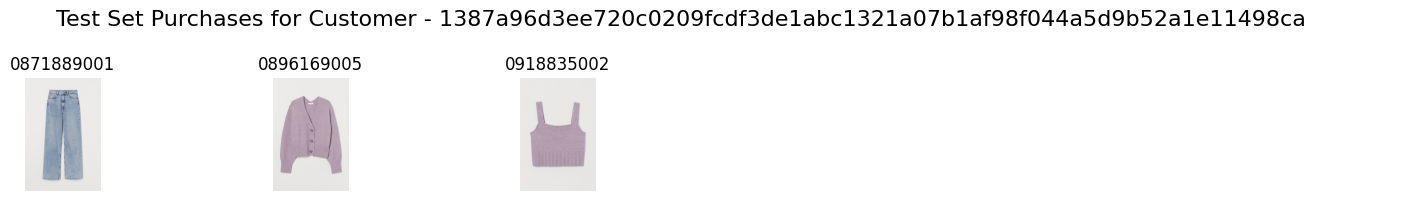

In [19]:

total_recall = 0
count = 0

# Generate recommendations and calculate recall for each test customer
for customer_id in test_customers:
    # Get the actual articles purchased by this customer in the test set
    actual_purchases = test_data[test_data['customer_id'] == customer_id]['article_id'].values
    
    # Get predicted articles using SVD-based recommendation function
    predicted_articles = recommend_articles_svd(customer_id)
    
    if len(actual_purchases) > 0:
        # Calculate recall@12 for this customer
        recall = recall_at_k(actual_purchases, predicted_articles, k=12)
        total_recall += recall
        count += 1

# Calculate average recall@12 over all test customers
average_recall = total_recall / count if count > 0 else 0
print(f'Average Recall@12 (Collaborative Filtering using SVD): {average_recall:.4f}')

# Get the articles the customer purchased in the training set
customer_train_purchases = transactions[transactions['customer_id'] == trial_customer_id]['article_id'].unique()

# Get the Collaborative filtering (SVD) recommendations for this customer
collaborative_svd_recommendations = recommend_articles_svd(trial_customer_id)

# Get the articles the customer purchased in the test set
customer_test_purchases = test_data[test_data['customer_id'] == trial_customer_id]['article_id'].unique()

# Display images of articles purchased in the training set
display_images_from_zip(customer_train_purchases, title=f"Training Set Purchases for Customer - {trial_customer_id}")

# Display images of Collaborative filtering (SVD) recommendations
display_images_from_zip(collaborative_svd_recommendations, title=f"Collaborative (SVD) recommendations for Customer - {trial_customer_id}")

# Display images of articles purchased in the test set
display_images_from_zip(customer_test_purchases, title=f"Test Set Purchases for Customer - {trial_customer_id}")


* We see the Recall@K metric has slightly dropped compared to content based model. However, it is still much higher than the baseline model.
* We also note that the recommendations are based on purchases by similar users (which SVD collaborative filtering does), so it did recommend some articles (such as trousers) which are not a part of the purchase history of the customer
* We also see that 1 articles purchased by the customer is included in the recommendations giving us an idea of how collaborative filtering (SVD) may have significantly improved the Recall@K metric over the baseline. 

Now we will try a Collaborative filtering approach using item-item similarity

### Collaborative Filtering using Item-Item Similarity

* We will now use Collaborative filtering based on Item-Item similarity. This is based on the similarity between articles (similar to content-based filtering, but based on customer purchase history).
* We will use the customer-article interaction matrix, where rows are customers and columns are articles, with entries representing the number of times a customer has purchased an article.
* Then we will compute the cosine similarity between items based on customer interactions (item-based collaborative filtering)
* For each customer in the test set, we will predict the top 12 articles by selecting the most similar items to the ones they have already purchased.

In [20]:
# Compute item-item cosine similarity based on the user-item matrix
item_similarity_matrix = cosine_similarity(user_item_matrix.T)  # Transpose to get item similarity

# Define the collaborative filtering recommendation function
def recommend_articles_collaborative(customer_id, n_recommendations=12):
    # Get the customer's index in the user-item matrix
    if customer_id not in customer_index:
        # If the customer is new, recommend the most purchased articles
        return most_purchased
    
    user_idx = customer_index[customer_id]
    
    # Get the articles the customer has purchased
    purchased_articles = user_item_matrix[user_idx].nonzero()[0]
    
    if len(purchased_articles) == 0:
        # If no purchases, recommend the most purchased articles
        return most_purchased
    
    # Compute scores for all items by taking the weighted average of item similarities
    article_scores = item_similarity_matrix[purchased_articles].mean(axis=0)
    
    # Exclude items the user has already purchased
    article_scores[purchased_articles] = -np.inf
    
    # Recommend top N articles
    top_indices = article_scores.argsort()[-n_recommendations:][::-1]
    recommended_articles = articles.iloc[top_indices]['article_id'].values
    
    return recommended_articles



Let us generate the predictions/recommendations for each customer present in the test set, calculate the Recall@K metric and visualize the recommendations

Average Recall@12 (Collaborative Filtering using item-item similarity): 0.0302


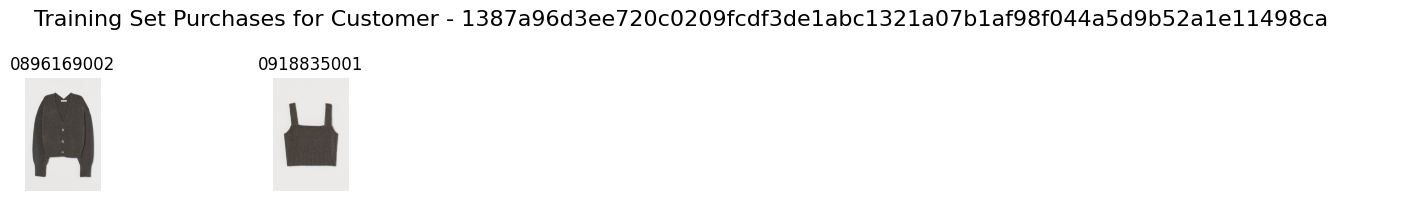

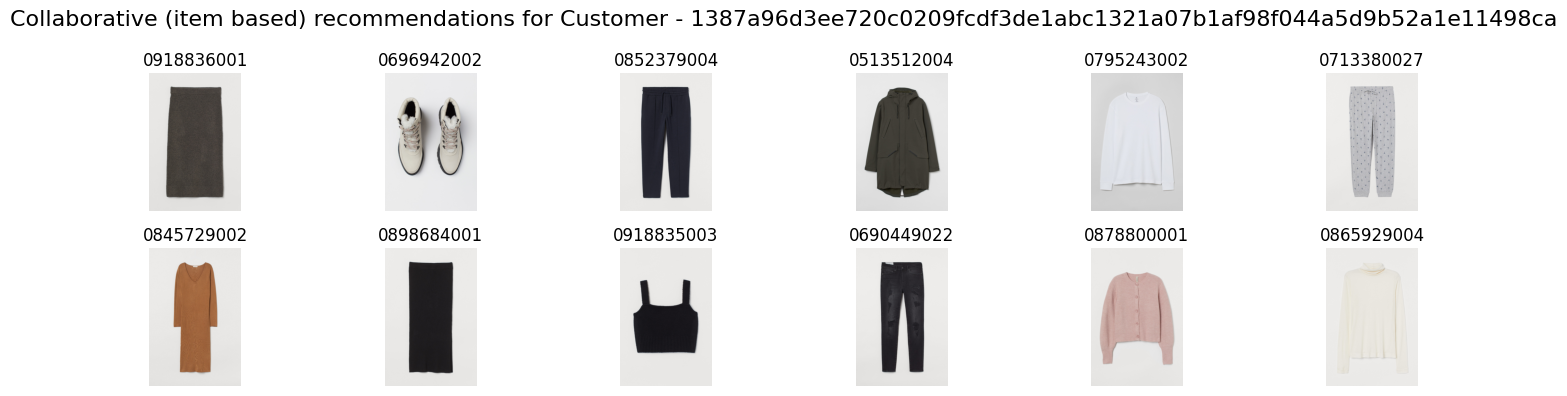

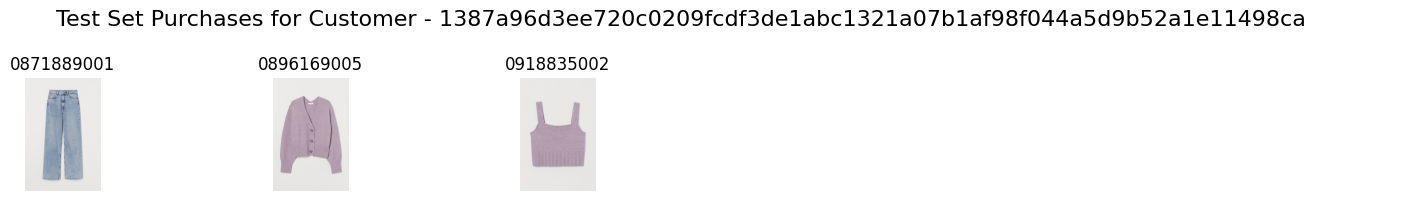

In [21]:

total_recall = 0
count = 0

# Generate recommendations and calculate recall for each test customer
for customer_id in test_customers:
    # Get the actual articles purchased by this customer in the test set
    actual_purchases = test_data[test_data['customer_id'] == customer_id]['article_id'].values
    
    # Get predicted articles using collaborative filtering recommendation function
    predicted_articles = recommend_articles_collaborative(customer_id)
    
    if len(actual_purchases) > 0:
        # Calculate recall@12 for this customer
        recall = recall_at_k(actual_purchases, predicted_articles, k=12)
        total_recall += recall
        count += 1

#Calculate average recall@12 over all test customers
average_recall = total_recall / count if count > 0 else 0
print(f'Average Recall@12 (Collaborative Filtering using item-item similarity): {average_recall:.4f}')

# Get the articles the customer purchased in the training set
customer_train_purchases = transactions[transactions['customer_id'] == trial_customer_id]['article_id'].unique()

# Get the Collaborative filtering (item-item similarity) recommendations for this customer
collaborative_item_based_recommendations = recommend_articles_collaborative(trial_customer_id)

# Get the articles the customer purchased in the test set
customer_test_purchases = test_data[test_data['customer_id'] == trial_customer_id]['article_id'].unique()

# Display images of articles purchased in the training set
display_images_from_zip(customer_train_purchases, title=f"Training Set Purchases for Customer - {trial_customer_id}")

# Display images of Collaborative filtering (item-item similarity) recommendations
display_images_from_zip(collaborative_item_based_recommendations, title=f"Collaborative (item based) recommendations for Customer - {trial_customer_id}")

# Display images of articles purchased in the test set
display_images_from_zip(customer_test_purchases, title=f"Test Set Purchases for Customer - {trial_customer_id}")

* We see that the Recall@K metric is slightly lower compared to Content based and SVD Collaborative Filtering, although it is still quite better than baseline prediction.
* We also note that the recommendations are made using similar items based on other user purchases (which item based collaborative filtering does), so it did recommend quite a diverse set of articles (such as shoes and trousers) which are not a part of the purchase history of the customer
* Although none of the articles purchased by the customer are included in the recommendations, there are some articles in the recommendation which are identical (but not exact matches) with the purchased articles in test set. This still demostrates how collaborative filtering (using item-item similarity) may have significantly improved the Recall@K metric over the baseline. 

Let us use a Hybird filtering approach which combines Content based and Collaborative filtering to see if it further improves the predictions

### Hybrid Recommender System

* Hybrid filtering combines both content-based filtering and collaborative filtering to leverage the strengths of both approaches. We will combine the results of content-based filtering and collaborative filtering (using SVD) to generate more accurate recommendations. 
* SVD Collaborative filtering is chosen over Collaborative Filtering using item-item similarity as SVD yielded in better Recall@K
* We will combine the predictions from both methods using a weighted average to produce final recommendations
* The weights for content based filtering (alpha) can be adjusted to tune the hybrid approach. We will use the same weight for content-based filtering and collaborative filtering by using an alpha of 0.5

In [22]:
# Hybrid filtering (simple weighted average approach)
def recommend_articles_hybrid(customer_id, n_recommendations=12, alpha=0.5):
    # Get content-based recommendations and collaborative filtering recommendations
    content_recommendations = recommend_articles_content_based(customer_id, n_recommendations=100)
    
    # Get recommendations from collaborative filtering (SVD)
    collaborative_recommendations = recommend_articles_svd(customer_id, n_recommendations=100)
    
    # Combine recommendations using weighted average
    combined_scores = {}
    
    # Assign weights to content-based recommendations
    for i, article_id in enumerate(content_recommendations):
        if article_id in combined_scores:
            combined_scores[article_id] += alpha * (100 - i)
        else:
            combined_scores[article_id] = alpha * (100 - i)
    
    # Assign weights to collaborative recommendations
    for i, article_id in enumerate(collaborative_recommendations):
        if article_id in combined_scores:
            combined_scores[article_id] += (1 - alpha) * (100 - i)
        else:
            combined_scores[article_id] = (1 - alpha) * (100 - i)
    
    # Sort the articles by their combined scores and return top N
    sorted_articles = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    recommended_articles = [article_id for article_id, _ in sorted_articles[:n_recommendations]]
    
    return recommended_articles


Let us generate the predictions/recommendations for each customer present in the test set, calculate the Recall@K metric and visualize the recommendations

Average Recall@12 (Hybrid Recommender System): 0.0306


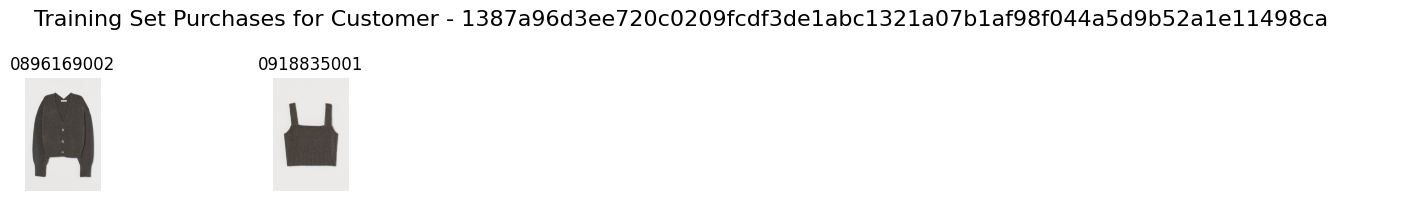

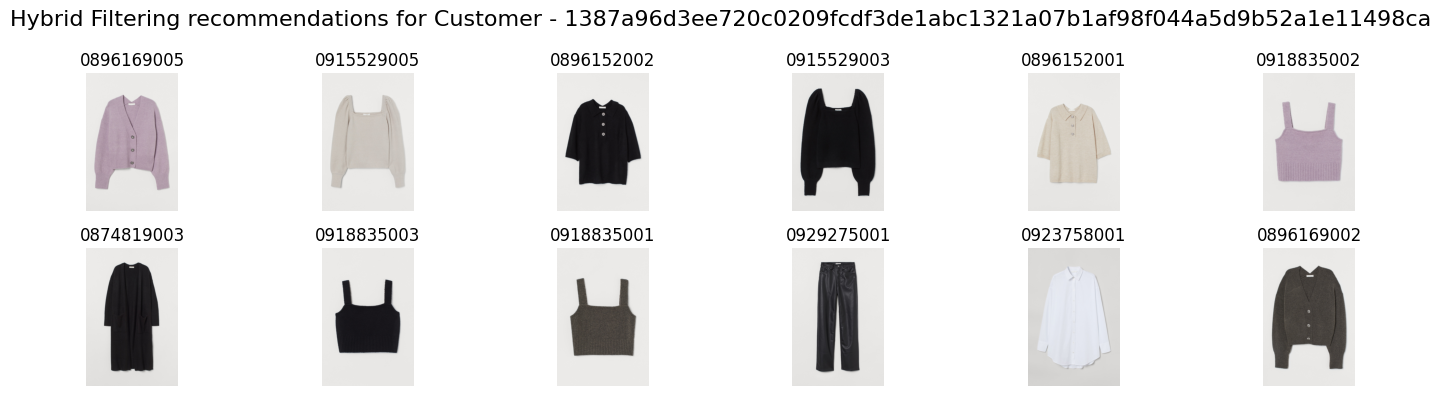

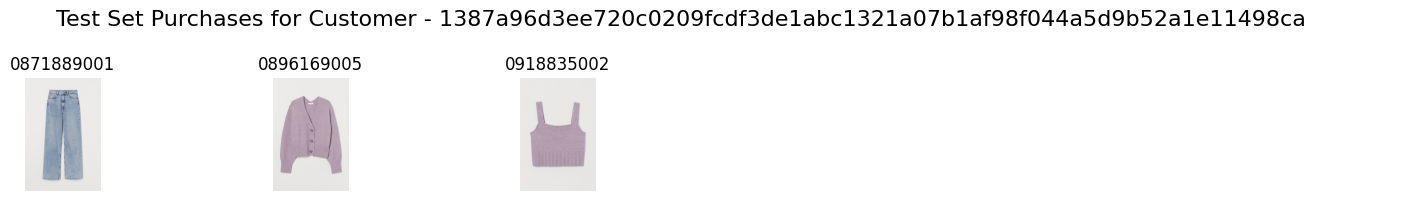

In [23]:
import warnings
warnings.filterwarnings('ignore')

total_recall = 0
count = 0

#Generate recommendations and calculate recall for each test customer
for customer_id in test_customers:
    # Get the actual articles purchased by this customer in the test set
    actual_purchases = test_data[test_data['customer_id'] == customer_id]['article_id'].values
    
    # Get predicted articles using collaborative filtering recommendation function
    predicted_articles = recommend_articles_hybrid(customer_id)
    
    if len(actual_purchases) > 0:
        # Calculate recall@12 for this customer
        recall = recall_at_k(actual_purchases, predicted_articles, k=12)
        total_recall += recall
        count += 1

#Calculate average recall@12 over all test customers
average_recall = total_recall / count if count > 0 else 0
print(f'Average Recall@12 (Hybrid Recommender System): {average_recall:.4f}')

# Get the articles the customer purchased in the training set
customer_train_purchases = transactions[transactions['customer_id'] == trial_customer_id]['article_id'].unique()

# Get the Hybrid filtering recommendations for this customer
hybrid_filtering_recommendations = recommend_articles_hybrid(trial_customer_id)

# Get the articles the customer purchased in the test set
customer_test_purchases = test_data[test_data['customer_id'] == trial_customer_id]['article_id'].unique()

# Display images of articles purchased in the training set
display_images_from_zip(customer_train_purchases, title=f"Training Set Purchases for Customer - {trial_customer_id}")

# Display images of Hybrid filtering recommendations
display_images_from_zip(hybrid_filtering_recommendations, title=f"Hybrid Filtering recommendations for Customer - {trial_customer_id}")

# Display images of articles purchased in the test set
display_images_from_zip(customer_test_purchases, title=f"Test Set Purchases for Customer - {trial_customer_id}")

* The resulting Recall@K is 0.0306 which is better than the Collaborative Filtering, but it falls short compared to the Content Based Filtering
* We see there are quite some recommendations which are physically identical to the ones purchased by the customer in train set which is likely due to the influence of Content Based Filtering in the Hybrid system
* We also see a couple of articles recommended are not physically similar to the previously purchased items by the customer, which might be due to the influence of Collaborative Filtering in the Hybrid system
* Overall, Hybrid recommender system is a middle ground between Content Based Filtering and Collaborative Filtering and has shown improved performance over Collaborative Filtering

### Summary of Results

|Model|Recall@K|
|:-----------|:--------:|
|Baseline Model| 0.0077 |
|Content Based Filtering| 0.0465 |
|Collaborative Filtering using SVD| 0.0305 |
|Collaborative Filtering using item-item similarity| 0.0302 |
|Hybrid Recommender System| 0.0306 |

### Conclusions

* **Baseline Model:** The baseline model achieved a Recall@K 0.0077, indicating that it provided very limited relevant recommendations. This highlights the importance of more sophisticated approaches to enhance recommendation quality.

* **Content-Based Filtering:** The content-based filtering model achieved a recall of 0.0465, showing a significant improvement over the baseline and all other models. This suggests that utilizing item/article features allows for better personalization and relevance in recommendations.

* **Collaborative Filtering Techniques:** Both collaborative filtering methods (SVD and item-item similarity) yielded similar Recall@K scores (0.0305 and 0.0302). While these models improved upon the baseline, they did not outperform the content-based approach. This may simply be due to the richness of data present in the item features (article descriptions) which content based filtering utilizes and colloborative filtering does not.

* **Hybrid Recommender System:** The hybrid recommender system recorded the highest Recall@K of 0.0306, surpassing both the collaborative filtering methods. This suggests that while hybrid approaches can enhance performance, they may not fully leverage the advantages of content-based filtering in this instance, due to a relatively poor performance by Collaborative filtering

The results demonstrate that content-based filtering is the most effective approach among those tested, providing the highest Recall@k. The collaborative filtering methods show improvements over the baseline but do not match the performance of the content-based method. The hybrid model, while better than the collaborative methods, still highlights the dominance of content-based strategies in this context.

### Future improvements
* Incorporating additional features which were left out (such as article groups, prices, etc) into the Content based filtering model can improve Recall@K
* Expanding the training set to transactions earlier than 3 days could yield even better Recall@K rates, but may drastically increase compute

### Thank you!